<a href="https://colab.research.google.com/github/tennille-bernard/Kal-Academy-Assignments/blob/main/Assignment_4_1_TB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This assignment focuses on developing a convolutional neural network that reads the road sign images and classifies them correctly.  
Source data can be found here: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign?resource=download

**Import the packages**

In [1]:
#importing relevant packages to set up the json file and determine filepath
import os
import pandas as pd
from zipfile import ZipFile
!mkdir ~p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
#downloading the dataset
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

#Unzip the dataset to view the files
!unzip gtsrb-german-traffic-sign.zip -d gtsrb_data

Streaming output truncated to the last 5000 lines.
  inflating: gtsrb_data/train/5/00005_00053_00010.png  
  inflating: gtsrb_data/train/5/00005_00053_00011.png  
  inflating: gtsrb_data/train/5/00005_00053_00012.png  
  inflating: gtsrb_data/train/5/00005_00053_00013.png  
  inflating: gtsrb_data/train/5/00005_00053_00014.png  
  inflating: gtsrb_data/train/5/00005_00053_00015.png  
  inflating: gtsrb_data/train/5/00005_00053_00016.png  
  inflating: gtsrb_data/train/5/00005_00053_00017.png  
  inflating: gtsrb_data/train/5/00005_00053_00018.png  
  inflating: gtsrb_data/train/5/00005_00053_00019.png  
  inflating: gtsrb_data/train/5/00005_00053_00020.png  
  inflating: gtsrb_data/train/5/00005_00053_00021.png  
  inflating: gtsrb_data/train/5/00005_00053_00022.png  
  inflating: gtsrb_data/train/5/00005_00053_00023.png  
  inflating: gtsrb_data/train/5/00005_00053_00024.png  
  inflating: gtsrb_data/train/5/00005_00053_00025.png  
  inflating: gtsrb_data/train/5/00005_00053_00026.png

**Importing the remaining packages**  
1.  Numpy, Pandas, Matplotlib, Seaborn
2.  TensorFlow and Keras
3.  Sklearn
4.  cv2, random

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50, VGG19, MobileNet
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import cv2
import random

**Loading the Dataset**

In [4]:
train_csv_path = 'gtsrb_data/Train.csv'
test_csv_path = 'gtsrb_data/Test.csv'

In [5]:
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

print("Training Data:")
print(train_df.head())

print("\nTesting Data:")
print(test_df.head())

Training Data:
   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   

                             Path  
0  Train/20/00020_00000_00000.png  
1  Train/20/00020_00000_00001.png  
2  Train/20/00020_00000_00002.png  
3  Train/20/00020_00000_00003.png  
4  Train/20/00020_00000_00004.png  

Testing Data:
   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId            Path
0     53      54       6       5      48      49       16  Test/00000.png
1     42      45       5       5      36      40        1  Test/00001.png
2     48      52       6       6      43      47       38  Test/00002.png
3     27      29       5       5      22      24       33  Test/00003.png
4     60      57 

**Preprocessing the data:**

In [6]:
#Defining the size of the images
image_height, image_width = 32,32
number_of_classes = 43

In [7]:
#Creating a function for preprocessing
def image_preprocess(path, img_size =(image_height, image_width)):
    img = cv2.imread(f'gtsrb_data/{path}')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #converts image to RGB
    img = cv2.resize(img, img_size) # resizes the image to the target size
    img = img /255
    return img

In [8]:
# Load training images and labels
X_train = np.array([image_preprocess(path) for path in train_df['Path']])
y_train = train_df['ClassId'].values

In [9]:
# One-hot encode labels
y_train = to_categorical(y_train, number_of_classes)

In [10]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [11]:
print("Training Data Shape:", X_train.shape)
print("Validation Data Shape:", X_val.shape)

Training Data Shape: (31367, 32, 32, 3)
Validation Data Shape: (7842, 32, 32, 3)


Plotting a few sample images.

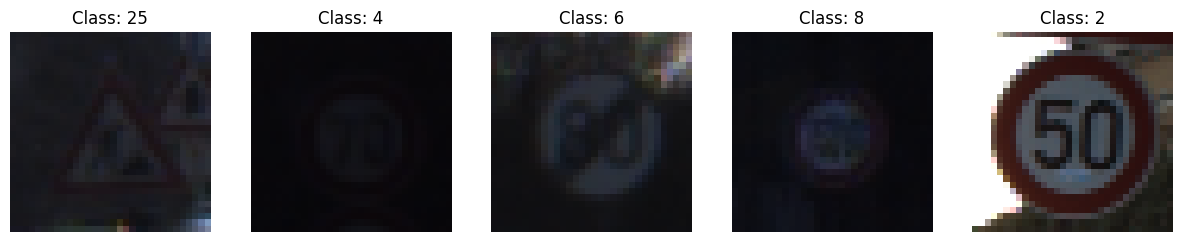

In [12]:
def plot_samples(data, labels, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        idx = random.randint(0, len(data) - 1)
        axes[i].imshow(data[idx])
        axes[i].set_title(f"Class: {np.argmax(labels[idx])}")
        axes[i].axis('off')
    plt.show()

# Plot sample training images
plot_samples(X_train, y_train)

**Creating functions for evaluating the model and plotting the training curves**

In [13]:
#Evaluating the model on the test data, then print test accuracy and loss.
#Inputs/Arguments:
#     model: trained Keras model
#     X_test: numpy array of test data
#     y_test: true labels consisting of a one-hot encoded numpy array

def evaluate_model(model, X_test, y_test):
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose = 0)  #verbose = 0 will supress output during function execution
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
    print(f"Test Loss: {test_loss:.4f}")

In [14]:
def plot_training_curves(history):
   # Plots training and validation loss/accuracy curves.
   # Inputs/Arguments:
   #      history: a "history" object returned by model.fit().
   # Extract metrics from history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    # Plot Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

**Creating the CNN Model**  
The model will be created with Dropout, Batch Normalization, and Augmentation.

In [15]:
from tensorflow.keras import layers, models

model = models.Sequential([
    # Convolutional layers
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.MaxPooling2D(2,2),
    # Fully Connected Layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(43, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Compiling the model**

In [21]:
#model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 30, 30, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 13, 13, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 43)                  │           5,547 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 320,363 (1.22 MB)

 Trainable params: 320,171 (1.22 MB)

 Non-trainable params: 192 (768.00 B)

**Data Augmentation**

In [23]:
datagen = ImageDataGenerator(
    rotation_range=10,  #covers rotations up to 10 deg
    width_shift_range=0.1,  #covers images shifted horizontally by up to 10%
    height_shift_range=0.1,  #covers images shifted vertically by up to 10%
    shear_range=0.2,  #covers images that may be sheared (slanted and stretched)
    zoom_range=0.2,  #covers images zoomed in by up to 20%
    horizontal_flip=True,  #covers images flipped horizontally
    fill_mode = 'nearest'  #fills in missing pixels
)

datagen.fit(X_train)

**Training the model**  
***Early stopping*** is a regularization technique used to prevent overfitting in machine learning models, particularly in deep learning. It works by monitoring the model's performance on a validation set during training and stopping the training process when the performance on the validation set starts to degrade. This prevents the model from memorizing the training data and improves its ability to generalize to unseen data.

In [24]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) #defines callbacks
reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001) #reduces the learning rate when the model stops improving.

In [25]:
#Training the model with augmented data
history_2 = model.fit(datagen.flow(X_train, y_train, batch_size=64), epochs=10, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_learning_rate])

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


491/491 ━━━━━━━━━━━━━━━━━━━━ 91s 178ms/step - accuracy: 0.2246 - loss: 2.9391 - val_accuracy: 0.4668 - val_loss: 1.9254 - learning_rate: 0.0010
Epoch 2/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 89s 181ms/step - accuracy: 0.5896 - loss: 1.2546 - val_accuracy: 0.7756 - val_loss: 0.6655 - learning_rate: 0.0010
Epoch 3/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 87s 176ms/step - accuracy: 0.6973 - loss: 0.8973 - val_accuracy: 0.8545 - val_loss: 0.4316 - learning_rate: 0.0010
Epoch 4/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 90s 183ms/step - accuracy: 0.7639 - loss: 0.6841 - val_accuracy: 0.8869 - val_loss: 0.3156 - learning_rate: 0.0010
Epoch 5/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 86s 175ms/step - accuracy: 0.8016 - loss: 0.5905 - val_accuracy: 0.9137 - val_loss: 0.2536 - learning_rate: 0.0010
Epoch 6/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 85s 172ms/step - accuracy: 0.8265 - loss: 0.5071 - val_accuracy: 0.8892 - val_loss: 0.3164 - learning_rate: 0.0010
Epoch 7/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 87s 176ms/step - accuracy: 0.8382 - loss:

**Evaluating the model**

In [26]:
evaluate_model(model, X_val, y_val)

Test Accuracy: 96.86%
Test Loss: 0.0936


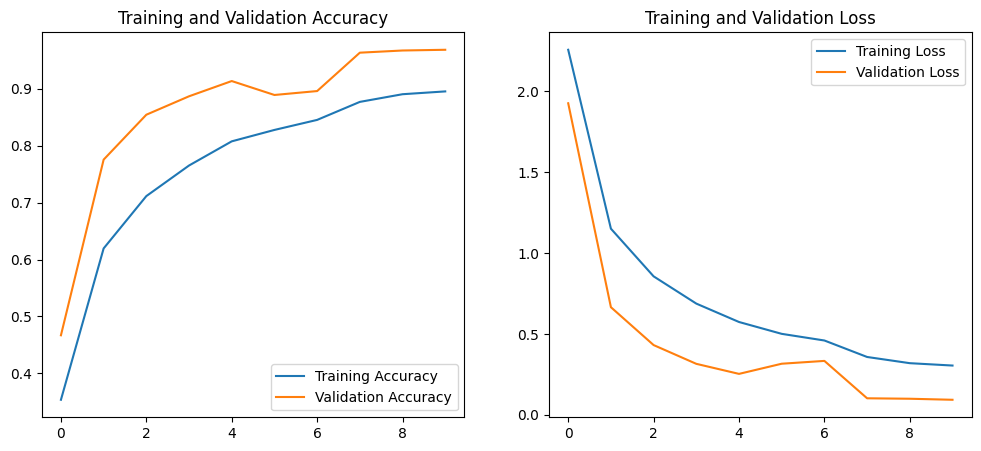

In [27]:
plot_training_curves(history_2)